In [6]:
import numpy as np
import matplotlib.pyplot as plt

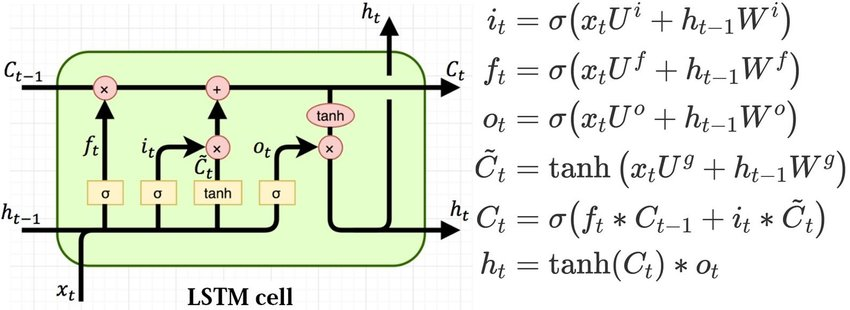

In [7]:
class LSTM:
    # LSTM cell (input, output, amount of recurrence, learning rate)
    def __init__ (self, input, output, recurrences, learning_rate):
        #input size
        self.x = np.zeros(input+output)
        #input size
        self.input = input + output
        #output 
        self.y = np.zeros(output)
        #output size
        self.output = output
        #cell state intialized as size of prediction
        self.cs = np.zeros(output)
        #how often to perform recurrence
        self.recurrences = recurrences
        #balance the rate of training (learning rate)
        self.learning_rate = learning_rate
        #init weight matrices for our gates
        #forget gate
        self.f = np.random.random((output, input+output))
        #input gate
        self.i = np.random.random((output, input+output))
        #cell state
        self.c = np.random.random((output, input+output))
        #output gate
        self.o = np.random.random((output, input+output))
        #forget gate gradient
        self.Gf = np.zeros_like(self.f)
        #input gate gradient
        self.Gi = np.zeros_like(self.i)
        #cell state gradient
        self.Gc = np.zeros_like(self.c)
        #output gate gradient
        self.Go = np.zeros_like(self.o)
    
   
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    
    def tangent(self, x):
        return np.tanh(x)
    
    
    def dtangent(self, x):
        return 1 - np.tanh(x)**2
  
    def forwardProp(self):
        f = self.sigmoid(np.dot(self.f, self.x))
        self.cs *= f
        i = self.sigmoid(np.dot(self.i, self.x))
        c = self.tangent(np.dot(self.c, self.x))
        self.cs += i * c
        o = self.sigmoid(np.dot(self.o, self.x))
        self.y = o * self.tangent(self.cs)
        return self.cs, self.y, f, i, c, o
    
   
    def backProp(self, e, pcs, f, i, c, o, dfcs, dfhs):
        
        e = np.clip(e + dfhs, -6, 6)
        
        do = self.tangent(self.cs) * e
        
        ou = np.dot(np.atleast_2d(do * self.dtangent(o)).T, np.atleast_2d(self.x))
        
        dcs = np.clip(e * o * self.dtangent(self.cs) + dfcs, -6, 6)
        
        dc = dcs * i
    
        cu = np.dot(np.atleast_2d(dc * self.dtangent(c)).T, np.atleast_2d(self.x))
      
        di = dcs * c
        
        iu = np.dot(np.atleast_2d(di * self.dsigmoid(i)).T, np.atleast_2d(self.x))
       
        df = dcs * pcs
        
        fu = np.dot(np.atleast_2d(df * self.dsigmoid(f)).T, np.atleast_2d(self.x))
       
        dpcs = dcs * f
        
        dphs = np.dot(dc, self.c)[:self.output] + np.dot(do, self.o)[:self.output] + np.dot(di, self.i)[:self.output] + np.dot(df, self.f)[:self.output] 
       
        return fu, iu, cu, ou, dpcs, dphs
            
    def update(self, fu, iu, cu, ou):
        #Update forget, input, cell, and output gradients
        self.Gf = 0.9 * self.Gf + 0.1 * fu**2 
        self.Gi = 0.9 * self.Gi + 0.1 * iu**2   
        self.Gc = 0.9 * self.Gc + 0.1 * cu**2   
        self.Go = 0.9 * self.Go + 0.1 * ou**2   
        
        #Update our gates using our gradients
        self.f -= self.learning_rate/np.sqrt(self.Gf + 1e-8) * fu
        self.i -= self.learning_rate/np.sqrt(self.Gi + 1e-8) * iu
        self.c -= self.learning_rate/np.sqrt(self.Gc + 1e-8) * cu
        self.o -= self.learning_rate/np.sqrt(self.Go + 1e-8) * ou
        return